In [ ]:
import shutil
import torch
import gpytorch
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np
import os
import pandas as pd
import sys
sys.path.append("/resnick/groups/enceladus/jyzhao/Scalable_GPs_jz/regression_gpytorch/src")
from training_utils.GPModel import GPModel, ExactGPModel
import time
from torch.utils.data import TensorDataset, DataLoader, Subset
import argparse
from training_utils.utils import set_seed, read_hdf5_with_site_id, predict_dataset
import geopandas as gpd
import scipy

In [3]:
from joblib import Parallel, delayed
import multiprocessing
import time
import contextlib
import joblib
from tqdm import tqdm
@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

In [7]:
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU for prediction")
else:
    device = torch.device("cpu")
    print("Using CPU for prediction")
# Set random seed
set_seed(62)

Using CPU for prediction
Random seed set as 62


In [9]:
# Load the formatted data for all eq
output_dir = "/resnick/groups/enceladus/jyzhao/Scalable_GPs_jz/regression_gpytorch/output"
format_data_dir = os.path.join(output_dir, 'formatted_data')
total_num_eqs = 8358
all_data_dir = os.path.join(format_data_dir, f'training_{total_num_eqs}_eqs')

all_data_file_train = os.path.join(all_data_dir, f'training_sites_training_eqs_2.00_ASK14_{total_num_eqs}_eqs_1_var_per_eq.h5')
all_data_x_train, all_data_y_train, all_data_site_id_train = read_hdf5_with_site_id(all_data_file_train)

all_data_file_test = os.path.join(all_data_dir, f'testing_sites_training_eqs_2.00_ASK14_{total_num_eqs}_eqs_1_var_per_eq.h5')
all_data_x_test, all_data_y_test, all_data_site_id_test = read_hdf5_with_site_id(all_data_file_test)

all_data_x = np.concatenate((all_data_x_train, all_data_x_test), axis=0)
all_data_y = np.concatenate((all_data_y_train, all_data_y_test), axis=0)
all_data_site_id = np.concatenate((all_data_site_id_train, all_data_site_id_test), axis=0)

# train_y_mean = all_data_y_train[:num_training_eqs].mean()
# all_data_y = all_data_y - train_y_mean
print(f"Loaded total number of data points: {all_data_x.shape[0]}")
# Load the earthquake IDs
rup_var_sample_file = os.path.join(all_data_dir, 'rup_var_sample_training.csv')
rup_var_df = pd.read_csv(rup_var_sample_file)
rup_var_df['eq_var_id'] = rup_var_df.apply(
    lambda row: int(row['eq_id']*1000 + row['rup_var_id']), axis=1)
condidate_eq_var_ids = rup_var_df['eq_var_id'][:total_num_eqs//2].values
testing_eq_var_ids = rup_var_df['eq_var_id'][total_num_eqs//2:].values
testing_mask = np.isin(all_data_x[:,0], testing_eq_var_ids)
candidate_mask = np.isin(all_data_x[:,0], condidate_eq_var_ids)
print(f"Number of testing points: {np.sum(testing_mask)}")

testing_x = all_data_x[testing_mask, :]
candidate_x = all_data_x[candidate_mask, :]
testing_y = all_data_y[testing_mask]
candidate_y = all_data_y[candidate_mask]
testing_site_id = all_data_site_id[testing_mask]
candidate_site_id = all_data_site_id[candidate_mask]

Loaded total number of data points: 2297076
Number of testing points: 1147532


In [15]:
# If use model trained on 400 eqs
source_lengthscale = 1.95
site_lengthscale = 6.85
path_lengthscale = 2.99

In [24]:
site_to_look = 's433'
test_x = testing_x[testing_site_id == site_to_look]
test_y = testing_y[testing_site_id == site_to_look]
print(f"Number of testing points at {site_to_look}: {test_x.shape[0]}")

Number of testing points at s433: 3529


In [28]:
3529 * len(candidate_x)*8*1024/1024/1024

31693287.3125

In [29]:
1/np.inf

0.0

In [31]:
num_src_within_scope = np.zeros((test_x.shape[0],))
for i in tqdm(range(test_x.shape[0])):
    num_src_within_scope[i] = np.sum(np.linalg.norm(test_x[i, 1:4] - candidate_x[:, 1:4], axis=1) < 5*source_lengthscale)

100%|██████████| 3529/3529 [03:05<00:00, 19.00it/s]


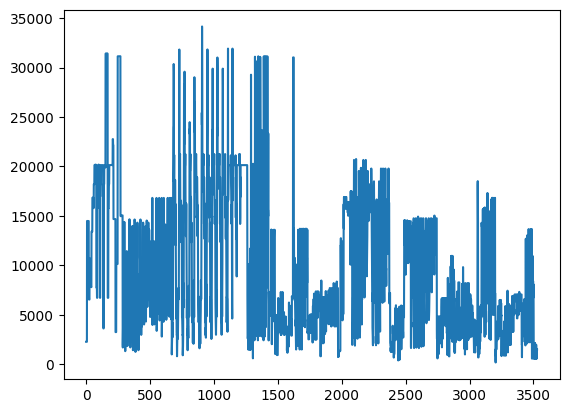

In [32]:
plt.plot(num_src_within_scope)

In [36]:
num_sites_within_scope = np.sum(np.linalg.norm(test_x[0, 4:7] - candidate_x[:, 4:7], axis=1) < 5*site_lengthscale)
print(f"Number of records involving sites within 5*{site_lengthscale} km: {num_sites_within_scope}")

record_sites_within_scope = np.where(np.linalg.norm(test_x[0, 4:7] - candidate_x[:, 4:7], axis=1) < 5*site_lengthscale)[0]
num_src_within_scope = np.zeros((test_x.shape[0],))
for i in tqdm(range(test_x.shape[0])):
    num_src_within_scope[i] = np.sum(np.linalg.norm(test_x[i, 1:4] - candidate_x[record_sites_within_scope, 1:4], axis=1) < 5*source_lengthscale)

Number of records involving sites within 5*6.85 km: 307195


100%|██████████| 3529/3529 [00:50<00:00, 70.51it/s]


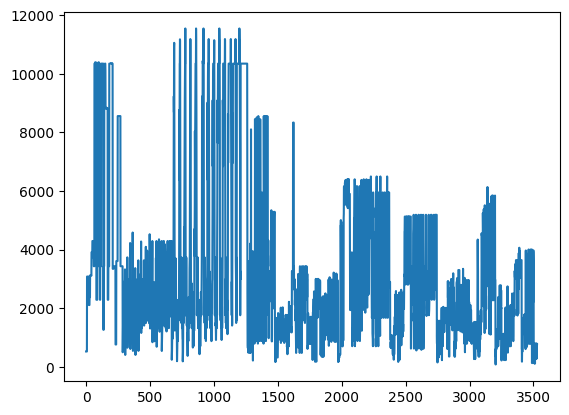

In [37]:
plt.plot(num_src_within_scope)

In [30]:
# Compute the distance matrix between testing and candidate points
source_matrix = scipy.sparse.csr_matrix((test_x[:,0].shape[0], candidate_x[:,0].shape[0]), dtype=np.float32)
for i in tqdm(range(test_x[:,0].shape[0]), total=test_x[:,0].shape[0]):
    src_dist = np.linalg.norm(test_x[i, 1:4] - candidate_x[:, 1:4], axis=1)
    src_dist[src_dist > 5*source_lengthscale] = np.inf
    # Store the reciprocal of the distances to make it sparse
    src_inv = 1/src_dist
    # Operate on each row is faster than column
    source_matrix[i, :] = scipy.sparse.csr_matrix(src_inv)

  0%|          | 0/3529 [00:00<?, ?it/s]/tmp/ipykernel_629688/3189327992.py:7: RuntimeWarning: divide by zero encountered in divide
  src_inv = 1/src_dist
/central/home/jyzhao/python_env/gpytorch/gpytorch/lib/python3.11/site-packages/scipy/sparse/_index.py:201: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)
 24%|██▍       | 839/3529 [01:52<06:01,  7.45it/s]


KeyboardInterrupt: 